# London Cycling Model

### London data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import shap
# Ignore copy warning
pd.options.mode.chained_assignment = None 

In [2]:
# Load London data 
inner = pd.read_csv('London/inner.csv')
outer = pd.read_csv('London/Outer London.csv')
central = pd.read_csv('London/central.csv')

In [3]:
# Add columns 
central['area'] = 'Central'
inner['area'] = 'Inner'
outer['area'] = 'Outer'
central['Survey wave (year)'] = [central['Survey wave (calendar quarter)'][i].split()[0] 
                                 for i in range(central.shape[0])]

In [4]:
# Join London dataframes 
london = pd.concat([central, inner, outer]).reset_index(drop=True)

In [5]:
# Get day of week and date from survey date column

london['Survey date'].replace(' ', np.NaN, inplace=True)
london['Survey date'] = london['Survey date'].fillna(', ')

london['days'] = [london['Survey date'][i].split(', ')[0] for i in range(london.shape[0])]
london['date'] = [london['Survey date'][i].split(', ')[1] for i in range(london.shape[0])]

london['Survey date'].replace(', ', np.NaN, inplace=True)

day_mapping = {
    'lun' : 'Monday',
    'mar' : 'Tuesday',
    'mer' : 'Wednesday',
    'jeu' : 'Thursday',
    'ven' : 'Friday',
    'sam' : 'Saturday',
    'dim' : 'Sunday',
    '' : np.NaN
}

london['day_of_week'] = london['days'].map(day_mapping)
london.date.replace('', np.nan, inplace=True)
london.drop(['Survey date', 'days'], axis=1, inplace=True)

In [6]:
# Drop columns less important in analysis 
london = london.drop(['Survey wave (calendar quarter)', 'Equivalent financial quarter', 'Location', 
                      'Time', 'Direction', 'Start minute', 'Number of unknown cycles'], axis=1)

In [7]:
# Rename columns 
london.rename(columns={'Site ID':'site', 'Weather':'weather', 'Period':'period', 'Start hour':'hour', 
                       'Number of private cycles':'private', 'Number of cycle hire bikes':'hired', 
                       'Total cycles':'total_cycles', 'Survey wave (year)':'year', 'Number of male cycles':'male',
                       'Number of female cycles':'female'}, inplace=True)

In [8]:
# Standardise weather 
london.weather = london.weather.str.lower()
london.weather = london.weather.fillna('')

wet_list = ['wet', 'rain', 'drizz', 'shower', 'damp', 'mizzle', 'down pour', 'deluge', 'spit', ' shr']
good_list = ['sun', 'fine', 'fair', 'warm', 'hot', 'good', 'mild', 'clear', 'bright']
poor_list = ['cloud', 'overcast', 'cold', 'cool', 'wind', 'dull', 'dark', 'chill', 'hazy', 'foggy', 
             'blustery', 'mist', 'snow', 'hail', 'sleet', 'storm', 'thunder']

weather_cat = []
for weather_text in london.weather:
    if any(word in weather_text for word in wet_list) and 'dry' in weather_text:
        weather_cat.append('mixed')
    elif 'dry' in weather_text:
        weather_cat.append('dry')
    elif any(word in weather_text for word in wet_list):
        weather_cat.append('wet')
    elif (any(word in weather_text for word in good_list) and any(word in weather_text for word in poor_list)) or weather_text == 'mixed':
        weather_cat.append('mixed')       
    elif any(word in weather_text for word in good_list):
        weather_cat.append('good')        
    elif any(word in weather_text for word in poor_list):
        weather_cat.append('poor')       
    else:
        weather_cat.append(np.nan)    
        
london['weather'] = weather_cat

In [9]:
# Convert date data 
london['date'] = pd.to_datetime(london['date'], errors='coerce')
london['month'] = london['date'].dt.month

# Convert year from object to integer type
london = london.astype({'year':'int'})

### Differences in cycling 

Text(0.5, 0, 'Number of cyclists')

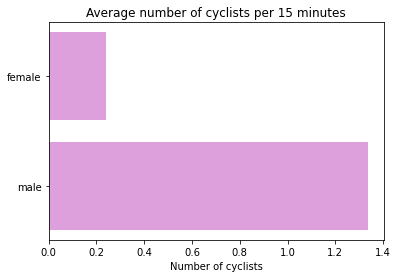

In [10]:
# Male vs female cyclists (Outer London)
sex_df = pd.DataFrame(london[['male', 'female']].mean(), columns=['mean']).reset_index()
plt.barh(sex_df['index'], sex_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

Text(0.5, 0, 'Number of cyclists')

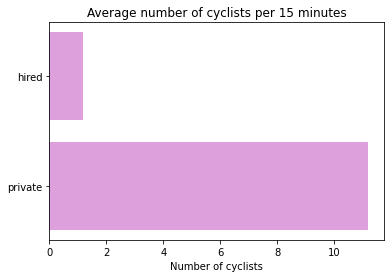

In [11]:
# Private vs hired cycles (Inner and Central London)
private_df = pd.DataFrame(london[['private', 'hired']].mean(), columns=['mean']).reset_index()
plt.barh(private_df['index'], private_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

### Infrastructure data 

In [12]:
# Get borough of each London site 
sites = pd.read_excel('London/Biking sites.xlsx')[[
    'UnqID', 'Borough']].rename(columns={'UnqID':'site', 'Borough':'borough'})
london = london.merge(sites, how='left', on='site')

# Group london data by borough
london_boroughs = london.groupby(['borough']).mean()[['total_cycles']].reset_index()

In [15]:
# Get borough infrastructure data 
borough_df = pd.read_csv('london_infrastructure/borough_infrastructure.csv')

In [16]:
# Merge borough data together
borough_df = pd.merge(london_boroughs, borough_df, how='outer', on='borough')

# Correlations between mean cyclists and surveyed infrastructure 
for col in ['cycle_parking_count', 'restricted_point_count', 'signage_count', 'signal_count', 'traffic_calming_count', 
            'crossing_count', 'advanced_stop_line_count', 'restricted_route_count', 'cycle_lane_track_count']:
    print(col, '\n', np.corrcoef(borough_df['total_cycles'], borough_df[col]), '\n')

cycle_parking_count 
 [[1.         0.58849277]
 [0.58849277 1.        ]] 

restricted_point_count 
 [[ 1.         -0.13278599]
 [-0.13278599  1.        ]] 

signage_count 
 [[1.        0.0227193]
 [0.0227193 1.       ]] 

signal_count 
 [[1.         0.75412353]
 [0.75412353 1.        ]] 

traffic_calming_count 
 [[ 1.         -0.00523325]
 [-0.00523325  1.        ]] 

crossing_count 
 [[ 1.         -0.44456452]
 [-0.44456452  1.        ]] 

advanced_stop_line_count 
 [[1.         0.62821962]
 [0.62821962 1.        ]] 

restricted_route_count 
 [[1.         0.19811602]
 [0.19811602 1.        ]] 

cycle_lane_track_count 
 [[ 1.         -0.46381071]
 [-0.46381071  1.        ]] 



### Modelling 

In [17]:
# Load distance to infrastructure data 
updated_sites = pd.read_csv('London/updated_sites.csv')

In [18]:
# Add infrastructure data to dataframe 

distance_data = updated_sites[['UnqID', 'closest_restricted_point', 'restricted_point_count_100m',
 'restricted_point_count_1000m', 'closest_signal', 'signal_count_100m', 'signal_count_1000m',
 'closest_crossing', 'crossing_count_100m', 'crossing_count_1000m', 'closest_advanced_stop_line',
 'advanced_stop_line_count_100m', 'advanced_stop_line_count_1000m', 'closest_restricted_route',
 'restricted_route_count_100m', 'restricted_route_count_1000m', 'closest_cycle_parking',
 'cycle_parking_count_100m', 'cycle_parking_count_1000m']].rename(columns={'UnqID':'site'})

london = london.merge(distance_data, how='left', on='site')

In [19]:
# Select features for model 
london_model = london[['year', 'month', 'day_of_week', 'period', 'hour', 'area', 'borough', 'weather', 
                       'total_cycles', 'closest_restricted_point', 'restricted_point_count_100m', 
                       'restricted_point_count_1000m', 'closest_signal', 'signal_count_100m', 
                       'signal_count_1000m', 'closest_crossing', 'crossing_count_100m', 
                       'crossing_count_1000m', 'closest_advanced_stop_line', 'advanced_stop_line_count_100m', 
                       'advanced_stop_line_count_1000m', 'closest_restricted_route', 
                       'restricted_route_count_100m', 'restricted_route_count_1000m', 'closest_cycle_parking', 
                       'cycle_parking_count_100m', 'cycle_parking_count_1000m']]

# Exclude rows with null values 
london_model = london_model.dropna()

# ~1.6% of total rows dropped
(london_model.shape[0]/london.shape[0])*100

98.41891796508082

In [20]:
# Change month column from float to int
london_model.month = london_model.month.astype(int)

# Set categorical categories as category 
cat_cols = ['month', 'day_of_week', 'period', 'area', 'borough', 'weather']
for col in cat_cols:
    london_model[col] = london_model[col].astype('category')
    london_model[col] = london_model[col].cat.codes

# Record categorical columns 
cat_index = []
for col in cat_cols:
    cat_index.append(london_model.columns.get_loc(col))

In [21]:
# CatBoost model 
X = london_model.drop(['total_cycles'], axis=1)
y = london_model.total_cycles

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.25, random_state=13)

train_dataset = cb.Pool(X_train, y_train, cat_features=cat_index) 
eval_dataset = cb.Pool(X_eval, y_eval, cat_features=cat_index)
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_index)

model = cb.CatBoostRegressor(loss_function='Poisson', 
                             learning_rate=0.1, 
                             depth=10, 
                             iterations=2000)

model.fit(train_dataset, eval_set=eval_dataset, 
          early_stopping_rounds=100, use_best_model=True, verbose=True)

0:	learn: -1.5848899	test: -1.5842957	best: -1.5842957 (0)	total: 1.28s	remaining: 42m 44s
1:	learn: -3.8536743	test: -3.8537403	best: -3.8537403 (1)	total: 2.39s	remaining: 39m 45s
2:	learn: -5.9271959	test: -5.9267463	best: -5.9267463 (2)	total: 3.56s	remaining: 39m 26s
3:	learn: -7.7070273	test: -7.7055966	best: -7.7055966 (3)	total: 4.67s	remaining: 38m 51s
4:	learn: -9.2646497	test: -9.2631164	best: -9.2631164 (4)	total: 5.87s	remaining: 39m 3s
5:	learn: -10.6846824	test: -10.6822848	best: -10.6822848 (5)	total: 7.09s	remaining: 39m 15s
6:	learn: -11.8958411	test: -11.8934435	best: -11.8934435 (6)	total: 8.27s	remaining: 39m 13s
7:	learn: -12.9432422	test: -12.9401769	best: -12.9401769 (7)	total: 9.39s	remaining: 38m 58s
8:	learn: -13.8336246	test: -13.8312375	best: -13.8312375 (8)	total: 10.4s	remaining: 38m 25s
9:	learn: -14.6016967	test: -14.5984002	best: -14.5984002 (9)	total: 11.7s	remaining: 38m 41s
10:	learn: -15.2758095	test: -15.2709914	best: -15.2709914 (10)	total: 12.7s

86:	learn: -20.4116952	test: -20.3799838	best: -20.3799838 (86)	total: 1m 37s	remaining: 35m 38s
87:	learn: -20.4291686	test: -20.3973992	best: -20.3973992 (87)	total: 1m 38s	remaining: 35m 36s
88:	learn: -20.4324044	test: -20.3998444	best: -20.3998444 (88)	total: 1m 39s	remaining: 35m 34s
89:	learn: -20.4364470	test: -20.4035138	best: -20.4035138 (89)	total: 1m 40s	remaining: 35m 33s
90:	learn: -20.4482667	test: -20.4153865	best: -20.4153865 (90)	total: 1m 41s	remaining: 35m 31s
91:	learn: -20.4522690	test: -20.4189681	best: -20.4189681 (91)	total: 1m 42s	remaining: 35m 29s
92:	learn: -20.4619110	test: -20.4282610	best: -20.4282610 (92)	total: 1m 43s	remaining: 35m 25s
93:	learn: -20.4655812	test: -20.4317805	best: -20.4317805 (93)	total: 1m 44s	remaining: 35m 21s
94:	learn: -20.4686487	test: -20.4347496	best: -20.4347496 (94)	total: 1m 45s	remaining: 35m 18s
95:	learn: -20.4771449	test: -20.4430944	best: -20.4430944 (95)	total: 1m 46s	remaining: 35m 16s
96:	learn: -20.4836073	test: -

170:	learn: -20.8624478	test: -20.8082378	best: -20.8082378 (170)	total: 3m 7s	remaining: 33m 28s
171:	learn: -20.8639264	test: -20.8093205	best: -20.8093205 (171)	total: 3m 8s	remaining: 33m 26s
172:	learn: -20.8651360	test: -20.8101857	best: -20.8101857 (172)	total: 3m 9s	remaining: 33m 25s
173:	learn: -20.8658567	test: -20.8106494	best: -20.8106494 (173)	total: 3m 10s	remaining: 33m 24s
174:	learn: -20.8699962	test: -20.8145117	best: -20.8145117 (174)	total: 3m 12s	remaining: 33m 22s
175:	learn: -20.8707316	test: -20.8147277	best: -20.8147277 (175)	total: 3m 13s	remaining: 33m 22s
176:	learn: -20.8722591	test: -20.8162052	best: -20.8162052 (176)	total: 3m 14s	remaining: 33m 20s
177:	learn: -20.8736216	test: -20.8167836	best: -20.8167836 (177)	total: 3m 15s	remaining: 33m 19s
178:	learn: -20.8754312	test: -20.8184229	best: -20.8184229 (178)	total: 3m 16s	remaining: 33m 18s
179:	learn: -20.8787814	test: -20.8214731	best: -20.8214731 (179)	total: 3m 17s	remaining: 33m 18s
180:	learn: -

254:	learn: -21.0047926	test: -20.9273929	best: -20.9273929 (254)	total: 4m 41s	remaining: 32m 5s
255:	learn: -21.0050923	test: -20.9275046	best: -20.9275046 (255)	total: 4m 42s	remaining: 32m 3s
256:	learn: -21.0082163	test: -20.9304614	best: -20.9304614 (256)	total: 4m 43s	remaining: 32m 2s
257:	learn: -21.0087869	test: -20.9309201	best: -20.9309201 (257)	total: 4m 44s	remaining: 32m 1s
258:	learn: -21.0097611	test: -20.9316339	best: -20.9316339 (258)	total: 4m 45s	remaining: 32m
259:	learn: -21.0109478	test: -20.9322419	best: -20.9322419 (259)	total: 4m 46s	remaining: 31m 58s
260:	learn: -21.0110461	test: -20.9322834	best: -20.9322834 (260)	total: 4m 47s	remaining: 31m 57s
261:	learn: -21.0125101	test: -20.9335013	best: -20.9335013 (261)	total: 4m 48s	remaining: 31m 56s
262:	learn: -21.0131990	test: -20.9337790	best: -20.9337790 (262)	total: 4m 49s	remaining: 31m 55s
263:	learn: -21.0136278	test: -20.9339628	best: -20.9339628 (263)	total: 4m 51s	remaining: 31m 54s
264:	learn: -21.01

338:	learn: -21.0812167	test: -20.9824288	best: -20.9824288 (338)	total: 6m 16s	remaining: 30m 45s
339:	learn: -21.0817802	test: -20.9828837	best: -20.9828837 (339)	total: 6m 17s	remaining: 30m 43s
340:	learn: -21.0828959	test: -20.9833055	best: -20.9833055 (340)	total: 6m 18s	remaining: 30m 42s
341:	learn: -21.0834458	test: -20.9833862	best: -20.9833862 (341)	total: 6m 19s	remaining: 30m 42s
342:	learn: -21.0838911	test: -20.9836912	best: -20.9836912 (342)	total: 6m 21s	remaining: 30m 40s
343:	learn: -21.0853353	test: -20.9850272	best: -20.9850272 (343)	total: 6m 21s	remaining: 30m 38s
344:	learn: -21.0861265	test: -20.9851459	best: -20.9851459 (344)	total: 6m 23s	remaining: 30m 38s
345:	learn: -21.0867187	test: -20.9854741	best: -20.9854741 (345)	total: 6m 24s	remaining: 30m 36s
346:	learn: -21.0867893	test: -20.9854683	best: -20.9854741 (345)	total: 6m 25s	remaining: 30m 35s
347:	learn: -21.0874429	test: -20.9854685	best: -20.9854741 (345)	total: 6m 26s	remaining: 30m 35s
348:	learn

421:	learn: -21.1285430	test: -21.0049994	best: -21.0049994 (421)	total: 7m 51s	remaining: 29m 22s
422:	learn: -21.1289944	test: -21.0051966	best: -21.0051966 (422)	total: 7m 52s	remaining: 29m 21s
423:	learn: -21.1296892	test: -21.0057194	best: -21.0057194 (423)	total: 7m 53s	remaining: 29m 20s
424:	learn: -21.1306259	test: -21.0064365	best: -21.0064365 (424)	total: 7m 54s	remaining: 29m 18s
425:	learn: -21.1309505	test: -21.0063940	best: -21.0064365 (424)	total: 7m 55s	remaining: 29m 18s
426:	learn: -21.1317047	test: -21.0069467	best: -21.0069467 (426)	total: 7m 57s	remaining: 29m 17s
427:	learn: -21.1324683	test: -21.0071788	best: -21.0071788 (427)	total: 7m 58s	remaining: 29m 16s
428:	learn: -21.1327272	test: -21.0073278	best: -21.0073278 (428)	total: 7m 59s	remaining: 29m 14s
429:	learn: -21.1335667	test: -21.0078574	best: -21.0078574 (429)	total: 8m	remaining: 29m 14s
430:	learn: -21.1337673	test: -21.0078684	best: -21.0078684 (430)	total: 8m 1s	remaining: 29m 13s
431:	learn: -21

505:	learn: -21.1687643	test: -21.0208858	best: -21.0208858 (505)	total: 9m 29s	remaining: 28m
506:	learn: -21.1690098	test: -21.0208368	best: -21.0208858 (505)	total: 9m 30s	remaining: 27m 59s
507:	learn: -21.1693974	test: -21.0210747	best: -21.0210747 (507)	total: 9m 31s	remaining: 27m 58s
508:	learn: -21.1702627	test: -21.0218494	best: -21.0218494 (508)	total: 9m 32s	remaining: 27m 56s
509:	learn: -21.1703460	test: -21.0219338	best: -21.0219338 (509)	total: 9m 33s	remaining: 27m 54s
510:	learn: -21.1710850	test: -21.0222897	best: -21.0222897 (510)	total: 9m 34s	remaining: 27m 53s
511:	learn: -21.1713091	test: -21.0223681	best: -21.0223681 (511)	total: 9m 35s	remaining: 27m 52s
512:	learn: -21.1715833	test: -21.0223318	best: -21.0223681 (511)	total: 9m 36s	remaining: 27m 51s
513:	learn: -21.1719065	test: -21.0224287	best: -21.0224287 (513)	total: 9m 37s	remaining: 27m 50s
514:	learn: -21.1720267	test: -21.0224567	best: -21.0224567 (514)	total: 9m 38s	remaining: 27m 49s
515:	learn: -2

588:	learn: -21.1981502	test: -21.0329918	best: -21.0329918 (588)	total: 10m 59s	remaining: 26m 20s
589:	learn: -21.1983323	test: -21.0329244	best: -21.0329918 (588)	total: 11m 1s	remaining: 26m 19s
590:	learn: -21.1989788	test: -21.0334203	best: -21.0334203 (590)	total: 11m 2s	remaining: 26m 18s
591:	learn: -21.1990981	test: -21.0334327	best: -21.0334327 (591)	total: 11m 3s	remaining: 26m 17s
592:	learn: -21.1992950	test: -21.0335255	best: -21.0335255 (592)	total: 11m 4s	remaining: 26m 16s
593:	learn: -21.1996170	test: -21.0335939	best: -21.0335939 (593)	total: 11m 5s	remaining: 26m 15s
594:	learn: -21.1999563	test: -21.0335825	best: -21.0335939 (593)	total: 11m 6s	remaining: 26m 14s
595:	learn: -21.2002269	test: -21.0338411	best: -21.0338411 (595)	total: 11m 7s	remaining: 26m 13s
596:	learn: -21.2006328	test: -21.0339484	best: -21.0339484 (596)	total: 11m 8s	remaining: 26m 12s
597:	learn: -21.2009282	test: -21.0338195	best: -21.0339484 (596)	total: 11m 10s	remaining: 26m 10s
598:	lea

671:	learn: -21.2253835	test: -21.0330282	best: -21.0345061 (612)	total: 12m 36s	remaining: 24m 54s
672:	learn: -21.2257267	test: -21.0330016	best: -21.0345061 (612)	total: 12m 37s	remaining: 24m 53s
673:	learn: -21.2258535	test: -21.0330048	best: -21.0345061 (612)	total: 12m 38s	remaining: 24m 52s
674:	learn: -21.2267970	test: -21.0338788	best: -21.0345061 (612)	total: 12m 39s	remaining: 24m 50s
675:	learn: -21.2270305	test: -21.0336864	best: -21.0345061 (612)	total: 12m 40s	remaining: 24m 49s
676:	learn: -21.2272189	test: -21.0338037	best: -21.0345061 (612)	total: 12m 41s	remaining: 24m 48s
677:	learn: -21.2276993	test: -21.0340757	best: -21.0345061 (612)	total: 12m 42s	remaining: 24m 47s
678:	learn: -21.2278650	test: -21.0341073	best: -21.0345061 (612)	total: 12m 43s	remaining: 24m 46s
679:	learn: -21.2280083	test: -21.0339173	best: -21.0345061 (612)	total: 12m 45s	remaining: 24m 45s
680:	learn: -21.2282990	test: -21.0339125	best: -21.0345061 (612)	total: 12m 45s	remaining: 24m 43s


In [22]:
# Model performance 
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r_squared = r2_score(y_test, pred)
print(f'RMSE: {rmse}')
print(f'R Squared: {r_squared}')

RMSE: 12.67055815710229
R Squared: 0.6516024119067684


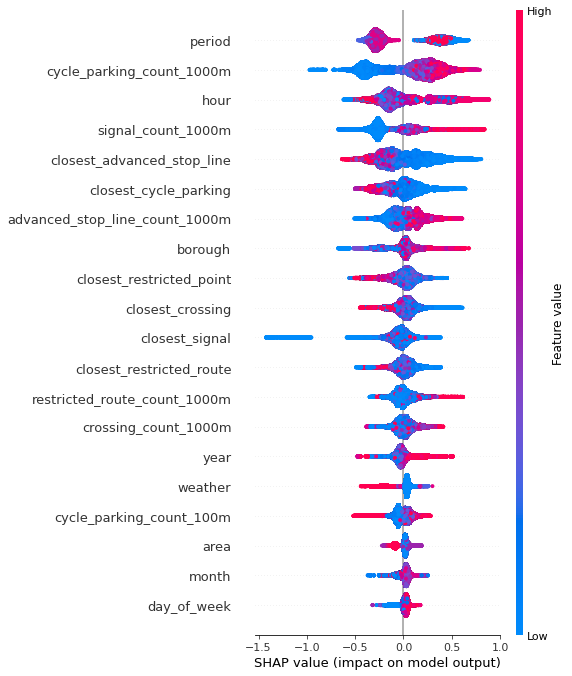

In [23]:
# Feature importance with infrastructure data 
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [ ]:
# CatBoost model 
X = london_model.drop(['total_cycles'], axis=1)
y = london_model.total_cycles

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.25, random_state=13)

train_dataset = cb.Pool(X_train, y_train, cat_features=cat_index) 
eval_dataset = cb.Pool(X_eval, y_eval, cat_features=cat_index)
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_index)

model = cb.CatBoostRegressor(loss_function='Poisson', 
                             learning_rate=0.1, 
                             depth=10, 
                             iterations=10000)

model.fit(train_dataset, eval_set=eval_dataset, 
          early_stopping_rounds=100, use_best_model=True, verbose=True)

In [65]:
# Model performance 
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r_squared = r2_score(y_test, pred)
print(f'RMSE: {rmse}')
print(f'R Squared: {r_squared}')

RMSE: 12.67055815710229
R Squared: 0.6516024119067684


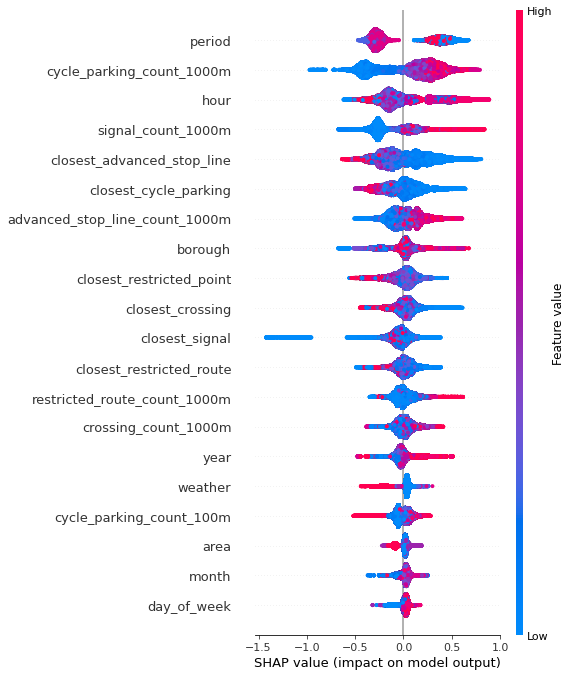

In [66]:
# Feature importance with infrastructure data 
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

# Regression Tree

Regression trees work on continuous data and try to predict a numeric value based on a set of independent features.

In [44]:
# import some more libraries
import statsmodels.api as sm
import math

import seaborn as sns
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

In [27]:
# Create the decision tree regressor class and fir the object to the data set
regressor = DecisionTreeRegressor(random_state = 0)

regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [41]:
# Evaluate the model prediction by predicting the response for the test data
y_pred = regressor.predict(X_test)

# Specify the MAE and MSE and RMSE
mae = round(metrics.mean_absolute_error(y_test, y_pred), 2)
mse = round(metrics.mean_squared_error(y_test, y_pred), 2)
rmse = round(math.sqrt(metrics.mean_squared_error(y_test, y_pred)),2)

print('Mean Absolute Error: ', mae)
print('Mean squared Error: ', rmse)
print('Root Mean Squared Error', rmse)

print(round(rmse-mae,2))

Mean Absolute Error:  5.65
Mean squared Error:  14.37
Root Mean Squared Error 14.37
8.72


The difference between RMSE and MAE determines how well the regression tree has performed. The closer to 0 the better the fit on the dataset. With a value of 8.32, the value is fairly low. 

To determine the feature importance, an evaluation is performed on the independent variables

Feature: 0, Score: 0.05122
Feature: 1, Score: 0.03794
Feature: 2, Score: 0.02996
Feature: 3, Score: 0.13305
Feature: 4, Score: 0.09527
Feature: 5, Score: 0.00042
Feature: 6, Score: 0.01058
Feature: 7, Score: 0.01023
Feature: 8, Score: 0.07307
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00407
Feature: 11, Score: 0.13171
Feature: 12, Score: 0.00594
Feature: 13, Score: 0.14074
Feature: 14, Score: 0.01691
Feature: 15, Score: 0.00103
Feature: 16, Score: 0.02086
Feature: 17, Score: 0.06756
Feature: 18, Score: 0.00500
Feature: 19, Score: 0.04160
Feature: 20, Score: 0.01900
Feature: 21, Score: 0.00081
Feature: 22, Score: 0.01888
Feature: 23, Score: 0.03735
Feature: 24, Score: 0.01101
Feature: 25, Score: 0.03577


<AxesSubplot:xlabel='Importance', ylabel='Variable'>

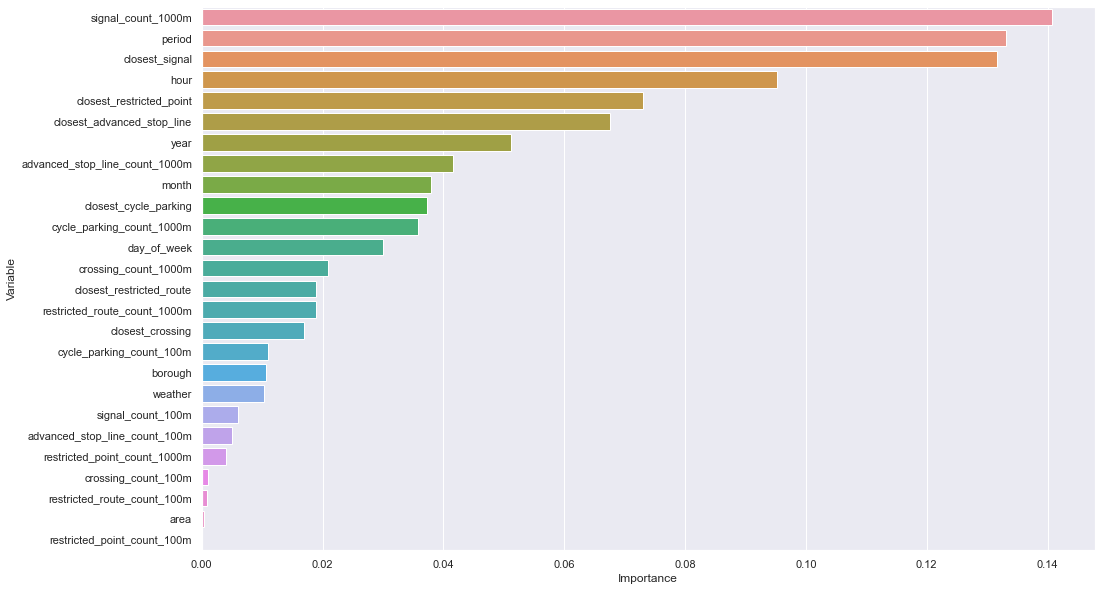

In [47]:
# get importance
importance = regressor.feature_importances_

# Summarize the feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# bring the Features into a df and visualize the feature importances
reg_tree_importance = pd.DataFrame({'Variable': X.columns,
                                    'Importance': importance})\
                                    .sort_values('Importance', ascending = False)

sns.set(rc={'figure.figsize':(16,10)})
sns.barplot(data = reg_tree_importance, x = 'Importance', y = 'Variable')

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='total_cycles', ylabel='Density'>

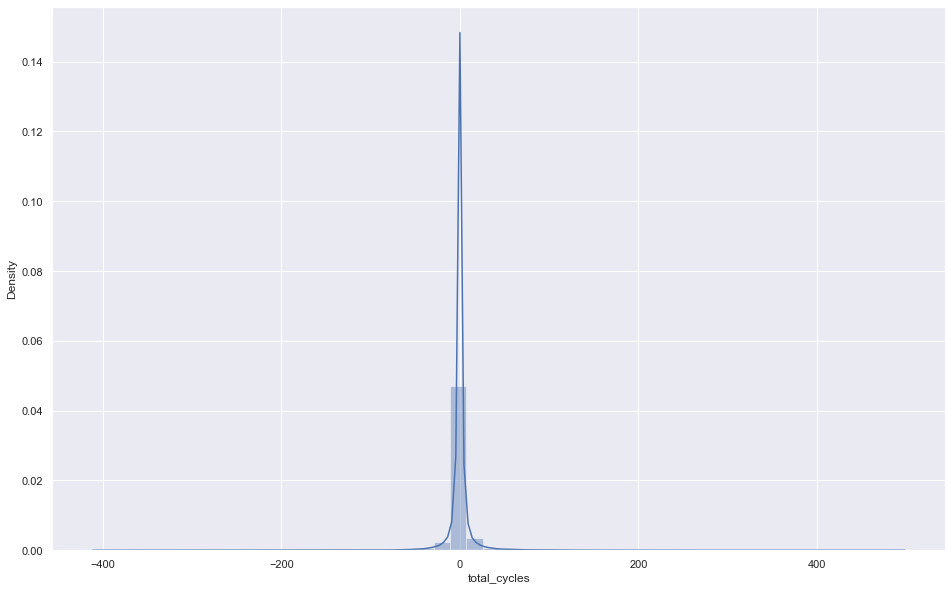

In [51]:
# Show the difference between labeled and predicted y values
sns.distplot(y_test-y_pred)

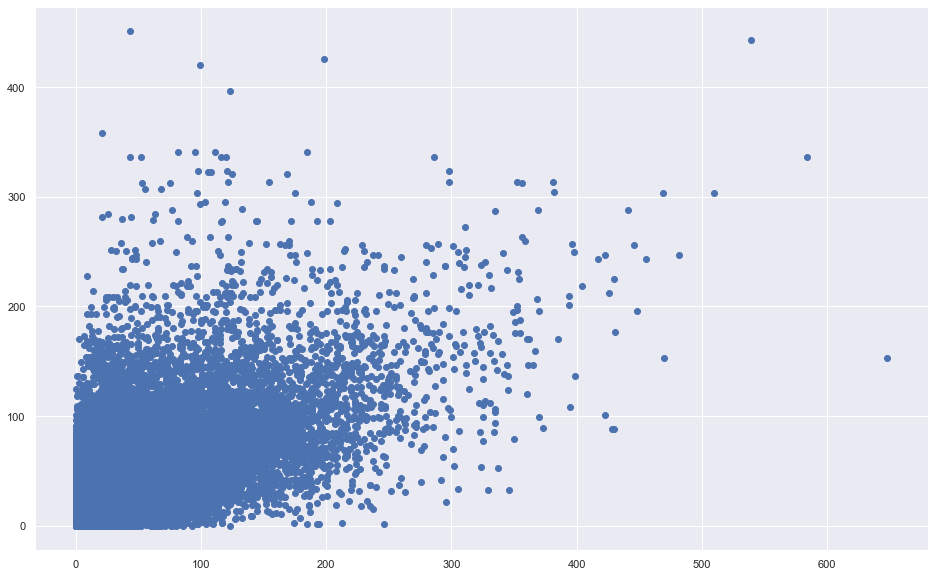

In [52]:
# Checking the predicted values using a scatter plot
plt.scatter(y_test,y_pred)

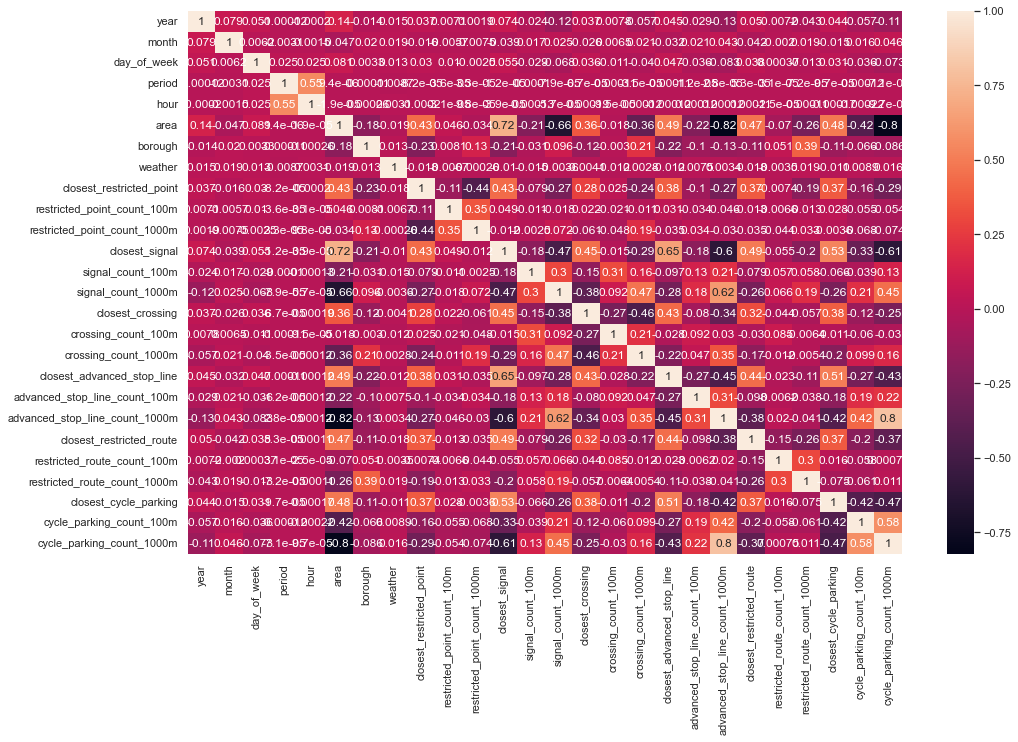

In [49]:
# Check for multicollinearity in the model
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot = True)
plt.show()

At first glance the notable correlation is betwen cycle parking counts and advanced stop line counts in km range. Closest signal and area also seem to be highly correlated. 

**Next Steps**

* Determine features to drop that are not as important to the model
* Create a Random forest to use against the model
* Create a ridge regression after feature selection